<a href="https://colab.research.google.com/github/bubka42/marrakech/blob/main/Marrackech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from typing import List, Tuple, Dict, Set, TypeVar
from collections import namedtuple
from enum import Enum
import time
from abc import ABC, abstractmethod
import random
from numpy.random import PCG64, SeedSequence, Generator, default_rng

In [ ]:
#@title Small Tests
a = np.array([range(7) for i in range(7)])
print(a[4,5])
type(a)
Pp = namedtuple('Content', ['colour', 'rug'])
type(Pp)
a = (0, 1)
b = (2, 3)
c = (a, b)
w, x, y, z = *a, *b
print(w, x, y, z)
Tt = Tuple[int, int]
ll = [[(col, row) for row in range(3)] for col in range(5)]
print(ll[3][2])
print(tuple(map(sum, zip(a, b))))
ss = {1, 2, 3}
ss.remove(2)
print(ss)
grid = np.mgrid[0:6:7j, 0:6:7j].reshape(2, -1).T
#print(grid)
plt.draw()
plt.show()
print({1, 2}.union({3, 4}))
bb = {-1, 7}
nn = {(0, 0), (1, 1), (2, 0), (1, -1)}
print({(c, r) for (c, r) in nn if not {c, r}.intersection(bb)})
ss = set()
ss.add(1)
print(ss)
ss - {1}
print(random.choice(list(nn)))
#print(Colour.RED.value)
#type(Marrakech)
dd = {1: 'a', 2: 'b'}
ss = set(dd)
print(ss)

In [ ]:
#@title Custom types

class Colour(Enum):
    NONE = 0
    RED = 1
    BLUE = 2
    YELLOW = 3
    GREEN = 4

class Direction(Enum):
    RIGHT = 3
    DOWN = 6
    LEFT = 9
    UP = 12

Cell = Tuple[int, int]
Rug = Tuple[Cell, Cell]

Assam: namedtuple = namedtuple('Assam', ['cell', 'direction'])

T: TypeVar = TypeVar('T')
Grid = List[List[T]]
CellState: namedtuple = namedtuple('CellState', ['colour', 'rug'])
Board = Grid[CellState]

Turn: namedtuple = namedtuple(
    'Turn', ['new_direction', 'roll', 'rug', 'colour']
)
Transcript = List[Turn]

In [ ]:
#@title Custom Errors

class AssamTooFarError(Exception):
    pass

class AssamInWayError(Exception):
    pass

class OutOfBoardError(Exception):
    pass

class InvalidTurnError(Exception):
    pass

class RugAlreadyThereError(Exception):
    pass

class NotARugError(Exception):
    pass

class AboutTurnError(Exception):
    pass

class SizeNotOddError(Exception):
    pass

class InvalidRollError(Exception):
    pass

class CellNotConnectedError(Exception):
    pass

class NegativeBalanceError(Exception):
    pass

class NoRugsLeftError(Exception):
    pass

class TooFewRugsError(Exception):
    pass

class InvalidColourError(Exception):
    pass

class PlayerNumberMismatchError(Exception):
    pass

class NoRoundsLeftError(Exception):
    pass

In [ ]:
#@title Class Definition: MarrakechPlayer

class MarrakechPlayer(ABC):
    NUM_RUGS: int = 15
    START_MONEY: int = 30

    def __init__(self, player_colour: Colour, seed: int,
                 num_rugs: int=NUM_RUGS, start_money: int=START_MONEY):
        self.seed: int = seed
        self.num_rugs: int = num_rugs
        if self.num_rugs < 1:
            raise TooFewRugsError
        else:
            self.rugs: list[Rug] = [Marrakech.NULL_RUG
                                    for round in range(self.num_rugs)]
        self.start_money: int = start_money
        self.balance: int = self.start_money
        if self.balance < 0:
            raise NegativeBalanceError
        if player_colour not in {Colour.RED, Colour.BLUE,
                                 Colour.YELLOW, Colour.GREEN}:
            raise InvalidColourError
        else:
            self.colour: Colour = player_colour
            self.rng: Generator = Generator(
                PCG64(SeedSequence((self.seed, self.colour.value)))
            )
        self.round = 0

    @abstractmethod
    def choose_rug(self, size: int, board: Board, assam: Assam) -> Rug:
        pass
        
    @abstractmethod
    def choose_face(self, size: int, board: Board,
                    assam: Assam) -> Direction:
        pass

    def reset(self):
        self.rugs = [Marrakech.NULL_RUG for round in range(self.num_rugs)]
        self.balance = self.start_money
        self.round = 0
        self.rng: Generator = Generator(
            PCG64(SeedSequence((self.seed, self.colour.value)))
        )

    def get_balance(self) -> int:
        return self.balance

    def deduct_fine(self, fine: int) -> None:
        self.balance -= fine
        if self.balance < 0:
            raise NegativeBalanceError
    
    def receive_fine(self, fine: int) -> None:
        self.balance += fine

    def record_rug(self, rug: Rug, round: int):
        if self.round >= self.num_rugs:
            raise NoRugsLeftError
        else:
            self.rugs[self.round] = rug
            self.round += 1

    def valid_neighbours(self, size: int, cell: Cell) -> Set[Cell]:
        col, row = cell
        neighbours = {(col + 1, row), (col, row + 1), (col - 1, row),
                      (col, row - 1)}
        border = {-1, size}
        return {(c, r) for (c, r) in neighbours
                if not {c, r}.intersection(border)}

    def valid_rugs(self, size: int, cell: Cell) -> Set[Rug]:
        neighbours = self.valid_neighbours(size, cell)
        rugs = set()
        for neighbour in neighbours:
            rugs = rugs.union(
                {(nn, neighbour)
                for nn in self.valid_neighbours(size, neighbour) - {cell}}
            )
        #print(rugs)
        return rugs

    def rug_already_there(self, board: Board, rug: Rug) -> bool:
        cell1, cell2 = rug
        col1, row1 = cell1
        return set(board[col1][row1].rug) == {cell1, cell2}

    def is_about_turn(self, direction1: Direction,
                      direction2: Direction) -> bool:
        return np.abs(direction1.value - direction2.value) == 6

    def get_colour(self) -> Colour:
        return self.colour

In [ ]:
#@title Class Definition: MarrakechPlayerRandom

class MarrakechPlayerRandom(MarrakechPlayer):
    def sample_rug(self, rugs: List[Rug]) -> Rug:
        rug_array = self.rng.choice(rugs)
        cell1_array, cell2_array = rug_array
        col1, row1, col2, row2 = *cell1_array, *cell2_array
        return ((col1, row1), (col2, row2))

    def choose_rug(self, size: int, board: Board, assam: Assam) -> Rug:
        valid_rugs = self.valid_rugs(size, assam.cell)
        return self.sample_rug([rug for rug in valid_rugs
                                if not self.rug_already_there(board, rug)])

    def choose_face(self, size: int, board: Board,
                    assam: Assam) -> Direction:
        valid_directions = [
            direction for direction in Direction.__members__.values()
            if not self.is_about_turn(direction, assam.direction)
        ]
        return self.rng.choice(valid_directions)

In [ ]:
#@title Class Definition: Marrakech

class Marrakech:
    SIZE: int = 7
    START_ASSAM: Assam = Assam(cell=(3, 3), direction=Direction.UP)
    NULL_CELL: Cell = (-1, -1)
    NULL_RUG: Rug = (NULL_CELL, NULL_CELL)
    NUM_PLAYERS: int = 2
    COLOUR_MAP = {
        Colour.RED: 'peachpuff',
        Colour.BLUE: 'lightskyblue',
        Colour.YELLOW: 'lemonchiffon',
        Colour.GREEN : 'springgreen'
    }
    EDGE_MAP = {
        Colour.RED: 'red',
        Colour.BLUE: 'blue',
        Colour.YELLOW: 'goldenrod',
        Colour.GREEN : 'green'
    }

    def __init__(self, ax, size: int=SIZE, start_assam: Assam=START_ASSAM,
                 num_players: int=NUM_PLAYERS):
        if not size % 2:
            raise SizeNotOddError
        else:
            self.ax = ax
            self.size: int = size
            self.board: Board = [[
                    CellState(colour=Colour.NONE, rug=Marrakech.NULL_RUG)
                    for row in range(self.size)
                ] for col in range(self.size)
            ]
            self.start_assam: Assam = start_assam
            self.assam: Assam = self.start_assam
            self.num_players: int = num_players
            self.last_rug: Rug = Marrakech.NULL_RUG
            self.last_colour: Colour = Colour.NONE
            self.ax.set_xlim([0, self.size])
            self.ax.set_ylim([0, self.size])
            self.ax.grid(True)
            self.ax.set_aspect('equal')
            self.ax.set_xticks(range(0, self.size, 1))
            self.ax.set_yticks(range(0, self.size, 1))
            
    def reset(self) -> None:
        self.board = [[
                CellState(colour=Colour.NONE, rug=Marrakech.NULL_RUG)
                for row in range(self.size)
            ] for col in range(self.size)
        ]
        self.assam = self.start_assam
        self.last_rug: Rug = Marrakech.NULL_RUG
        self.last_colour: Colour = Colour.NONE
        self.ax.set_xlim([0, self.size])
        self.ax.set_ylim([0, self.size])
        self.ax.grid(True)
        self.ax.set_aspect('equal')
        self.ax.set_xticks(range(0, self.size, 1))
        self.ax.set_yticks(range(0, self.size, 1))
    
    def get_state(self, cell: Cell) -> CellState:
        col, row = cell
        return self.board[col][row]

    def is_empty(self, cell: Cell) -> bool:
        return self.get_state(cell).colour == Colour.NONE

    def is_null_cell(self, cell: Cell) -> bool:
        col, row = cell
        return col, row == -1, -1

    def distance(self, cell1: Cell, cell2: Cell=None) -> int:
        if cell2 is None:
            cell2 = self.assam.cell
        col1, row1, col2, row2 = *cell1, *cell2
        return np.abs(col1 - col2) + np.abs(row1 - row2)

    def share_rug(self, cell1: Cell, cell2: Cell) -> bool:
        if self.is_empty(cell1) or self.is_empty(cell2):
            return False
        else:
            return (set(self.get_state(cell1).rug)
                    == set(self.get_state(cell2).rug))

    def set_state(self, cell: Cell, colour: Colour, rug: Rug) -> None:
        col, row = cell
        self.board[col][row] = CellState(colour, rug)

    def set_ax(self, ax) -> None:
        self.ax = ax

    def render_rug(self, rug: Rug, colour: Colour) -> None:
        spillover = 0.03
        cell1, cell2 = rug
        col1, row1, col2, row2 = *cell1, *cell2
        anchor = (min(col1, col2)-spillover, min(row1, row2)-spillover)
        rug_width = np.abs(col2 - col1) + 1 + 2*spillover
        rug_height = np.abs(row2 - row1) + 1 + 2*spillover
        rug_colour = Marrakech.COLOUR_MAP[colour]
        rug_edge = Marrakech.EDGE_MAP[colour]
        rug_patch = mpatches.Rectangle(anchor, width=rug_width,
                                       height=rug_height,
                                       facecolor=rug_colour,
                                       edgecolor=rug_edge, linewidth=3)
        self.ax.add_patch(rug_patch)

    def put_rug(self, rug: Rug, colour: Colour) -> None:
        cell1, cell2 = rug
        #print(self.assam.cell, cell1, cell2)
        if not self.distance(cell1, cell2) == 1:
            raise NotARugError
        elif self.assam.cell in rug:
            raise AssamInWayError
        elif self.distance(cell1) + self.distance(cell2) > 3:
            raise AssamTooFarError
        elif self.share_rug(cell1, cell2):
            raise RugAlreadyThereError
        else:
            self.set_state(cell1, colour, rug)
            self.set_state(cell2, colour, rug)
            self.render_rug(rug, colour)
            self.last_rug = rug
            self.last_colour = colour

    def face_assam(self, new_direction: Direction) -> None:
        if np.abs(self.assam.direction.value - new_direction.value) == 6:
            raise AboutTurnError
        else:
            current_cell = self.assam.cell
            self.assam = Assam(cell=current_cell, direction=new_direction)

    def next_assam(self) -> Assam:
        shift_map: Dict[Direction, Cell] = {
            Direction.RIGHT: (1, 0),
            Direction.DOWN: (0, -1),
            Direction.LEFT: (-1, 0),
            Direction.UP: (0, 1)
        }
        border_map: Dict[Cell, Tuple[Cell, Direction]] = {
            (0, -1): ((0, 0), Direction.RIGHT),
            (-1, 0): ((0, 0), Direction.UP),
            (self.size - 1, self.size): ((self.size - 1, self.size - 1),
                                         Direction.LEFT),
            (self.size, self.size - 1): ((self.size - 1, self.size - 1),
                                         Direction.DOWN)
        }
        for col in range(1, self.size):
            if col % 2:
                border_map[(col, self.size)] = ((col - 1, self.size - 1),
                                                Direction.DOWN)
                border_map[(col - 1, self.size)] = ((col, self.size - 1),
                                                    Direction.DOWN)
            else:
                border_map[(col, -1)] = ((col - 1, 0), Direction.UP)
                border_map[(col - 1, -1)] = ((col, 0), Direction.UP)
        for row in range(1, self.size):
            if row % 2:
                border_map[(self.size, row)] = ((self.size - 1, row - 1),
                                                Direction.LEFT)
                border_map[(self.size, row - 1)] = ((self.size - 1, row),
                                                    Direction.LEFT)
            else:
                border_map[(-1, row)] = ((0, row - 1), Direction.RIGHT)
                border_map[(-1, row - 1)] = ((0, row), Direction.RIGHT)
        next_cell = tuple(map(sum, zip(self.assam.cell,
                                       shift_map[self.assam.direction])))
        col, row = next_cell
        border = (-1, self.size)
        if col in border or row in border:
            new_cell, new_direction = border_map[next_cell]
            return Assam(new_cell, new_direction)
        else:
            return Assam(next_cell, self.assam.direction)

    def is_safe(self, cell: Cell, own_colour: Colour) -> bool:
        return self.get_state(cell).colour in (Colour.NONE, own_colour)

    def move_assam(self, roll: int) -> None:
        if not roll in range(1, 5):
            raise InvalidRollError
        else:
            for slipper in range(roll):
                self.assam = self.next_assam()

    def connected_helper(self, cell: Cell, marked: Set[Cell]) -> None:
        col, row = cell
        colour: Colour = self.get_state(cell).colour
        neighbours = {(col - 1, row), (col + 1, row), (col, row - 1),
                      (col, row + 1)}
        invalid_neighbours = set()
        for neighbour in neighbours:
            ncol, nrow = neighbour
            border = (-1, self.size)
            if ncol in border or nrow in border:
                invalid_neighbours.add(neighbour)
        valid_neighbours = neighbours - invalid_neighbours
        for neighbour in valid_neighbours:
            if not neighbour in marked and (
                self.get_state(neighbour).colour == colour
            ):
                marked.add(neighbour)
                self.connected_helper(neighbour, marked)

    def connected(self, cell: Cell) -> Set[Cell]:
        if self.is_empty(cell):
            raise CellNotConnectedError
        else:
            colour: Colour = self.get_state(cell).colour
            marked: Set[Cell] = {cell}
            self.connected_helper(cell, marked)
            return marked

    def penalty(self, cell: Cell) -> int:
        return len(self.connected(cell))
    
    def assam_penalty(self) -> int:
        return self.penalty(self.assam.cell)

    def execute_turn(self, turn: Turn, verbose: bool=False) -> None:
        self.face_assam(turn.new_direction)
        self.move_assam(turn.roll)
        if verbose:
            print(turn)
        if verbose and not self.is_safe(self.assam.cell, turn.colour):
            print("Penalty (", turn.colour.name, " to ",
                  self.get_state(self.assam.cell).colour.name,
                  "): ", self.penalty(self.assam.cell), sep = '')
        self.put_rug(turn.rug, turn.colour)

    def render_assam(self) -> None:
        col_correct = 0.03
        col_center, row_center = 0.5 + col_correct, 0.5
        face_offset = 0.13
        face_map: Dict[Direction, Tuple(float, float, float, float)] = {
            Direction.RIGHT: (col_center+face_offset, row_center,
                              300.0, 60.0),
            Direction.DOWN: (col_center, row_center-face_offset,
                             210.0, 330.0),
            Direction.LEFT: (col_center-face_offset, row_center,
                             120.0, 240.0),
            Direction.UP: (col_center, row_center+face_offset,
                           30.0, 150.0)
        }
        col, row = self.assam.cell
        assam_patch = mpatches.Circle((col+col_center, row+row_center),
                                      radius=0.2, color='black')
        self.ax.add_patch(assam_patch)
        col_offset, row_offset, start_angle, end_angle = face_map[
            self.assam.direction
        ]
        face_patch = mpatches.Arc((col+col_offset, row+row_offset),
                                  width=0.5, height=0.5,
                                  theta1=start_angle, theta2=end_angle)
        self.ax.add_patch(face_patch)

    def highlight_rug(self, rug: Rug, colour: Colour) -> None:
        spillover = 0.05
        cell1, cell2 = rug
        col1, row1, col2, row2 = *cell1, *cell2
        anchor = (min(col1, col2)-spillover, min(row1, row2)-spillover)
        rug_width = np.abs(col2 - col1) + 1 + 2*spillover
        rug_height = np.abs(row2 - row1) + 1 + 2*spillover
        rug_colour = Marrakech.COLOUR_MAP[colour]
        rug_edge = 'black'
        rug_patch = mpatches.Rectangle(anchor, width=rug_width,
                                       height=rug_height,
                                       facecolor=rug_colour,
                                       edgecolor=rug_edge, linewidth=4)
        self.ax.add_patch(rug_patch)

    def highlight_last_rug(self) -> None:
        self.highlight_rug(rug=self.last_rug, colour=self.last_colour)

    def playback(self, transcript: Transcript,
                 verbose: bool=False) -> None:
        for turn in transcript:
            self.execute_turn(turn, verbose)
        self.render_assam()
        self.highlight_last_rug()

    def step_playback(self, transcript: Transcript) -> None:
        for stop in range(1, len(transcript)):
            self.playback(transcript[:stop])
            self.reset()
        self.playback(transcript, verbose=True)

    def get_assam(self) -> Assam:
        return self.assam

    def get_board(self) -> Board:
        return self.board

    def get_assam_colour(self) -> Colour:
        return self.get_state(self.assam.cell).colour

    def calculate_score(self, colour: Colour) -> int:
        score: int = 0
        for col in range(self.size):
            for row in range(self.size):
                if self.get_state((col, row)).colour == colour:
                    score += 1
        return score


In [ ]:
#@title Class Definition: MarrakechGame

class MarrakechGame:
    NUM_PLAYERS: int = 4
    BOARD_SIZE: int = 7
    NUM_ROUNDS: int = 15
    COLOUR_ORDER: List[Colour] = [Colour.RED, Colour.BLUE, Colour.YELLOW,
                                  Colour.GREEN]
    START_ASSAM: Assam = Assam(cell = (3, 3), direction = Direction.UP)
    START_MONEY: int = 15
    DIE: List[int] = [1, 2, 2, 3, 3, 4]
    SEED: int = 0x87351080e25cb0fad77a44a3be03b492

    def __init__(self, seed: int=SEED, num_players: int=NUM_PLAYERS,
                 board_size: int=BOARD_SIZE, num_rounds: int=NUM_ROUNDS,
                 start_assam: Assam=START_ASSAM,
                 start_money: int=START_MONEY,
                 player_classes: List[type]=None):
        self.seed: int = seed
        self.num_players: int = num_players
        self.board_size: int = board_size
        self.num_rounds: int = num_rounds
        self.start_assam: Assam = start_assam
        self.start_money: int = start_money
        self.player_order: List[Colour] = MarrakechGame.COLOUR_ORDER[
            :self.num_players
        ]
        self.rng = Generator(PCG64(SeedSequence((self.seed, 0))))
        if player_classes:
            if not len(players_classes) == self.num_players:
                raise PlayerNumberMismatchError
            else:
                self.players: Dict[Colour, MarrakechPlayer] = {
                    colour:player_class(
                        player_colour=colour,
                        seed=self.seed,
                        num_rugs=self.num_rounds,
                        start_money=self.start_money
                    ) for player_class, colour in zip(player_classes,
                                                      player_order)
                } 
        else:
            self.players: Dict[Colour, MarrakechPlayer] = {
                colour:MarrakechPlayerRandom(
                    player_colour=colour,
                    seed=self.seed,
                    num_rugs=self.num_rounds,
                    start_money=self.start_money
                ) for colour in self.player_order
            }
        self.fig, self.axs = plt.subplots(self.num_rounds,
                                          self.num_players)
        self.figw = self.num_players * 5
        self.figh = self.num_rounds * 6
        self.fig.set_size_inches(w=self.figw, h=self.figh)
        self.lastax = self.axs[self.num_rounds-1, self.num_players-1]
        self.game = Marrakech(ax=self.lastax,
                              size=self.board_size,
                              start_assam=self.start_assam,
                              num_players=self.num_players)
        self.current_round = 0
        self.transcript = []
        self.active_players = self.players.copy()
        self.scores = None

    def throw_die(self) -> int:
        return self.rng.choice(MarrakechGame.DIE)

    def settle_penalty(self, colour: Colour) -> None:
        other_colour = self.game.get_assam_colour()
        if other_colour in set(self.active_players) - {colour}:
            full_fine = self.game.assam_penalty()
            balance = self.players[colour].get_balance()
            if full_fine > balance:
                self.players[other_colour].receive_fine(fine=balance)
                self.active_players.pop(colour, None)
            else:
                self.players[colour].deduct_fine(fine=full_fine)
                self.players[other_colour].receive_fine(fine=full_fine)

    def play_turn(self, player_colour: Colour,
                  verbose: bool=False) -> Turn:
        player = self.players[player_colour]
        current_board = self.game.get_board()
        current_assam = self.game.get_assam()
        next_face = player.choose_face(size=self.board_size,
                                       board=current_board,
                                       assam=current_assam)
        if verbose:
            print(next_face)
        self.game.face_assam(new_direction=next_face)
        next_roll = self.throw_die()
        if verbose:
            print(next_roll)
        self.game.move_assam(roll=next_roll)
        self.settle_penalty(colour=player_colour)
        new_assam = self.game.get_assam()
        if verbose:
            print(new_assam)
        next_rug = player.choose_rug(size=self.board_size,
                                     board=current_board,
                                     assam=new_assam)
        if verbose:
            print(next_rug)
        self.game.put_rug(rug=next_rug, colour=player_colour)
        return Turn(new_direction=next_face, roll=next_roll,
                    rug=next_rug, colour=player_colour)
        
    def play_round(self) -> None:
        self.current_round += 1
        if self.current_round > self.num_rounds:
            raise NoRoundsLeftError
        else:
            for colour in self.players:
                if colour in self.active_players:
                    self.transcript.append(self.play_turn(colour))

    def final_scores(self) -> Dict[Colour, int]:
        scores = {}
        for colour in self.active_players:
            scores[colour] = (self.game.calculate_score(colour)
                              + self.players[colour].get_balance())
        return scores

    def play_game(self) -> None:
        for round in range(self.num_rounds):
            self.play_round()
        self.scores = self.final_scores()
        for round in range(self.num_rounds):
            for player in range(self.num_players):
                num_turns = round*self.num_players + player + 1
                self.game.set_ax(ax=self.axs[round, player])
                self.game.reset()
                self.game.playback(transcript=self.transcript[:num_turns])
        print("Final scores: ", self.scores)

In [ ]:
#@title Test: Assam movements

mm = Marrakech()
rug = ((3, 4), (3, 5))
mm.put_rug(rug, Colour.BLUE)
rug2 = ((3, 4), (4, 4))
mm.put_rug(rug2, Colour.RED)
mm.move_assam(4)
print(mm.assam)
mm.face_assam(Direction.RIGHT)
mm.move_assam(4)
print(mm.assam)
mm.face_assam(Direction.UP)
mm.move_assam(4)
print(mm.assam)
mm.face_assam(Direction.DOWN)
mm.move_assam(4)
print(mm.assam)
mm.face_assam(Direction.LEFT)
mm.move_assam(4)
print(mm.assam)
mm.face_assam(Direction.DOWN)
mm.move_assam(4)
print(mm.assam)
mm.face_assam(Direction.DOWN)
mm.move_assam(4)
print(mm.assam)
mm.face_assam(Direction.UP)
mm.move_assam(1)
print(mm.assam)
mm.face_assam(Direction.LEFT)
mm.move_assam(2)
print(mm.assam)
mm.face_assam(Direction.DOWN)
mm.move_assam(3)
print(mm.assam)
mm.face_assam(Direction.LEFT)
mm.move_assam(4)
print(mm.assam)

In [ ]:
#@title Test: Recorded Game Playback

mm = Marrakech()
cr = Colour.RED
cb = Colour.BLUE
cy = Colour.YELLOW
cg = Colour.GREEN
du = Direction.UP
dd = Direction.DOWN
dl = Direction.LEFT
dr = Direction.RIGHT
t1 = Turn(dl, 3, ((1,2), (1,3)), cr)
t2 = Turn(dl, 2, ((1,3), (2,3)), cb)
t3 = Turn(dr, 1, ((2,2), (2,3)), cy)
t4 = Turn(dd, 3, ((2,0), (3,0)), cg)
t5 = Turn(dr, 2, ((3,2), (4,2)), cr)
t6 = Turn(du, 2, ((3,2), (3,3)), cb)
t7 = Turn(dl, 1, ((3,2), (3,1)), cy)
t8 = Turn(dl, 1, ((2,2), (3,2)), cg)
tt = [t1, t2, t3, t4, t5, t6, t7, t8]
mm.playback(tt)
#print(mm.penalty((2,2)), mm.penalty((1,3)))

In [ ]:
#@title Test: Matplotlib
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(w=20, h=12)
for axrow in axs:
    for ax in axrow:
        ax.set_xlim([-.5, 7.5])
        ax.set_ylim([-.5, 7.5])
        ax.grid(True)
        ax.set_aspect('equal')
        ax.set_xticks(range(0, 8, 1))
        ax.set_yticks(range(0, 8, 1))
print(type(fig), type(axs[0, 0]))
rug1 = mpatches.Rectangle((1, 1), width=2, height=1,
                          facecolor='lightblue',
                          edgecolor='blue', linewidth=4)
axs[0, 0].add_patch(rug1)
rug2 = mpatches.Rectangle((1, 1), width=1, height=2, facecolor='pink',
                          edgecolor='red', linewidth=4)
axs[0, 0].add_patch(rug2)
dd = Direction.__members__.values()
d = Direction.RIGHT
print([direction for direction in dd 
       if not np.abs(direction.value - d.value) == 6])

In [ ]:
#@title Test: Numpy Random Generator

entropy = 0x87351080e25cb0fad77a44a3be03b492
num = 3000
sequences = [SeedSequence((entropy, worker_id))
             for worker_id in range(num)]
generators = [Generator(PCG64(seq)) for seq in sequences]
dd1 = {}
dd2 = {}
ll1 = {}
ll2 = {}
for generator in generators:
    dd1[generator] = generator.choice(MarrakechGame.DIE)
    dd2[generator] = generator.choice(range(3)) + generator.choice(range(1,3))
for roll in range(1, 5):
    ll1[roll] = len([generator for generator in generators
                    if dd1[generator] == roll]) * 6 / num
    ll2[roll] = len([generator for generator in generators
                    if dd2[generator] == roll]) * 6 / num
# print(dd.values())
print(ll1)
print(ll2)
isinstance(generator, Generator)
print(sequences[0])
type(entropy)

In [ ]:
#@title Test: Generators

gg = (i*2 for i in range(5))
for i in range(6):
    print(next(gg, "That's all folks"))

Final scores:  {<Colour.RED: 1>: 38, <Colour.YELLOW: 3>: 34, <Colour.GREEN: 4>: 21}


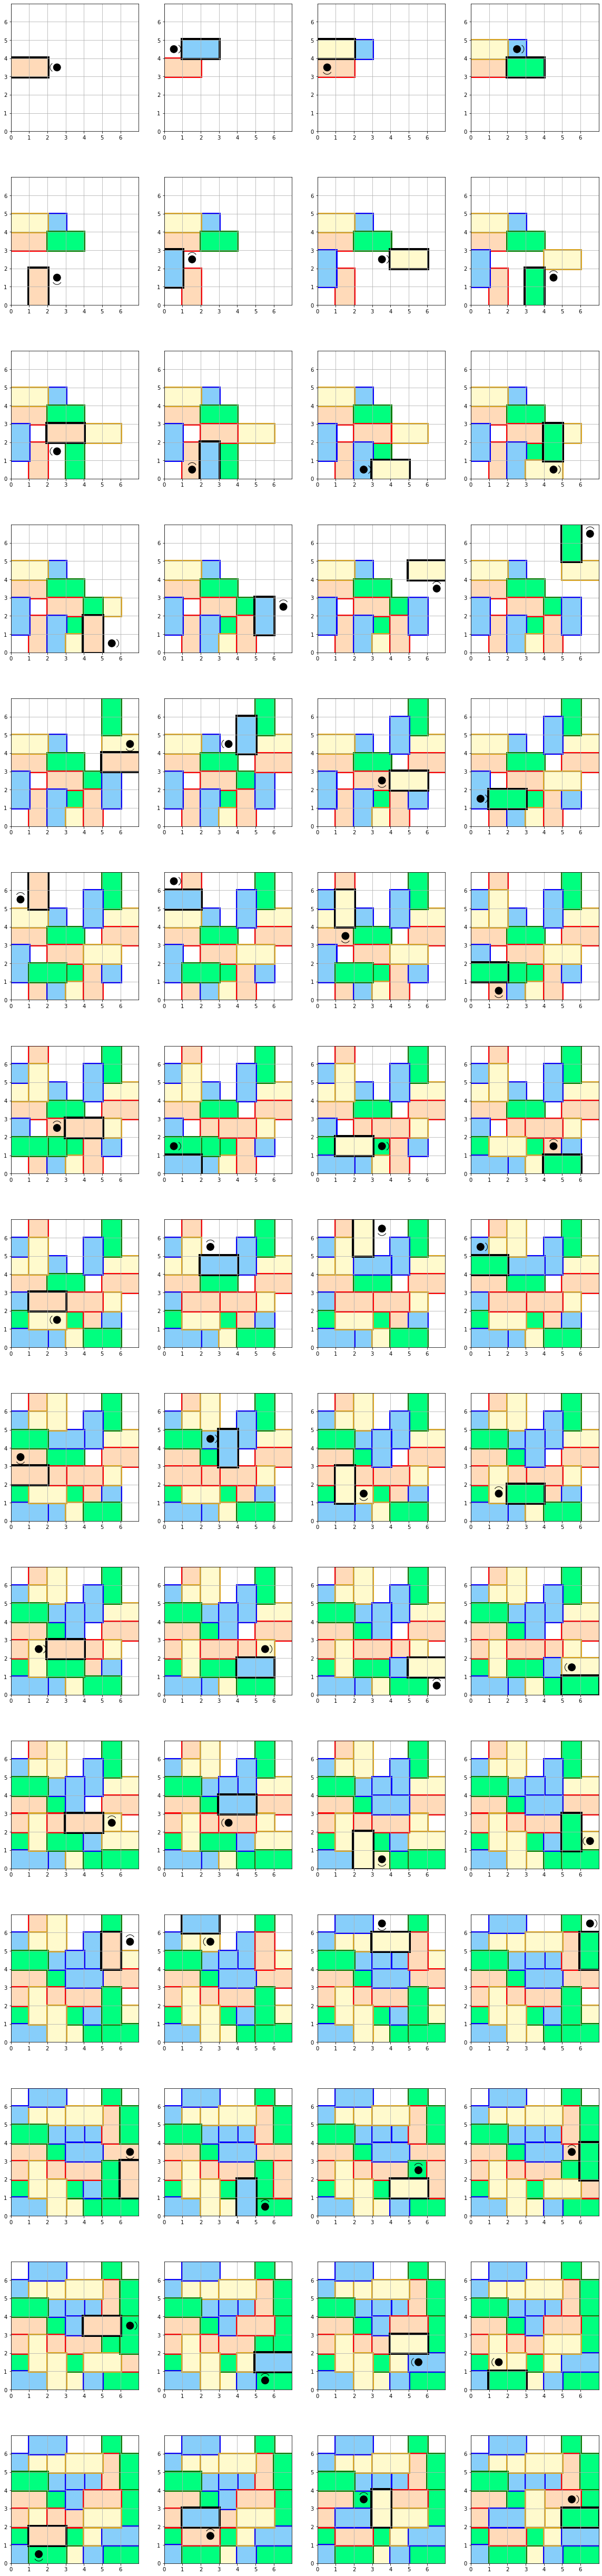

In [ ]:
mg = MarrakechGame()
mg.play_game()

In [ ]:
#@title Test: Choice

ggg = Generator(PCG64(SeedSequence(0)))
sss = [((0, 0), (1, 1)), ((0, 1), (1, 0))]
rrr = ggg.choice(sss)
cell1, cell2 = rrr
col1, row1, col2, row2 = *cell1, *cell2
rrn = ((col1, row1), (col2, row2))
print(rrn == sss[0], rrn == sss[1])
print(rrr == sss[0], rrr == sss[1])